In [10]:
# Import libraries
from datetime import datetime
import yfinance as yf
import pandas as pd 
from pandas_datareader import data as web
import numpy as np 
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models
from pypfopt import expected_returns
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [1]:
def get_data(startdate, enddate, stocklist): 
    """
    * This function retrieves the Adjusted close price from the historical data 
      for each stock in the list, for the given date range.
    * Enter dates as "yyyymmdd". 
    """
    start_date=datetime.strptime(startdate, '%Y%m%d').date()
    end_date=datetime.strptime(enddate, '%Y%m%d').date()
    data = yf.download(stocklist, start=start_date, end=end_date, progress=False)
    return data['Adj Close'].copy()

In [2]:
def split(df,date): 
    """This function divides the dataframe 
    in a train and test test splitted by the date given.
    """
    train=df.loc[df.index<date]
    test=df.loc[df.index>=date]
    return train, test

In [3]:
def plot_close(df, date):
    """
    In this function you can enter a date as 'yyyymmdd' and 
    see the plot of train and test  
    """
    train,test= split(df,date)

    fig, ax = plt.subplots(figsize=(20, 5))
    train.plot(ax=ax, label='Training', title='Adjusted Closing Prices')
    test.plot(ax=ax, label='Test Set')
    ax.axvline(date, color='black', ls='--')
    ax.legend(['Training', 'Test'])
    plt.show()

In [6]:
def add_lag(df):
    """This function adds two lag features to the dataframe.
    It assumes the latest column is the target. 
    """
    df=df.copy()
    df['t-1']=df['MSFT'].shift(1)
    df['t-2']=df['MSFT'].shift(2)
    df.dropna(inplace=True)
    return df 

In [7]:
def prepare_data(df, date):
    # Add lag to the DataFrame
    df_lagged = df.copy()
    df_lagged['t-1'] = df_lagged['MSFT'].shift(1)
    df_lagged['t-2'] = df_lagged['MSFT'].shift(2)
    df_lagged.dropna(inplace=True)
    
    # Split the DataFrame into train and test sets
    train,test= split(df_lagged,date)
    
    # Split the train and test sets into features and target
    X_train = train[['t-1', 't-2']]
    y_train = train['MSFT']
    X_test = test[['t-1', 't-2']]
    y_test = test['MSFT']
    
    # Combine train and test sets into X and y
    X = df_lagged[['t-1', 't-2']]
    y = df_lagged['MSFT']
    
    return X_train, X_test, y_train, y_test, X, y

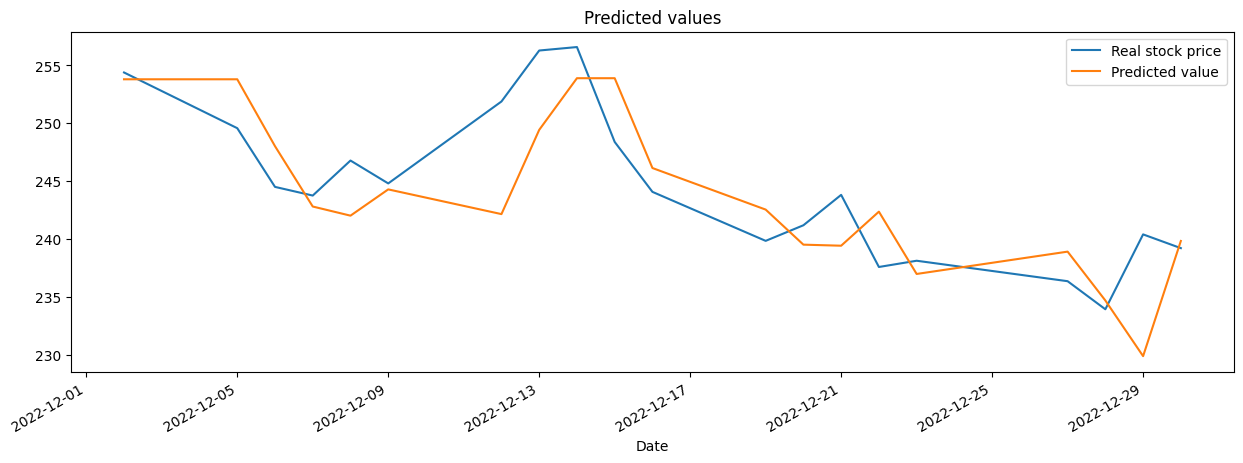

In [83]:
test.tail()

,MSFT,prediction
Date,,
2022-12-23,238.133545,236.992752
2022-12-27,236.367981,238.919754
2022-12-28,233.944031,234.702408
2022-12-29,240.407837,229.899338
2022-12-30,239.220825,239.839920


We will make a prediction for the coming 5 days: 

In [108]:
X.drop(X.tail().index,inplace = True)

In [111]:
X

,t-1,t-2
2018-01-04,81.113899,80.738152
2018-01-05,81.827820,81.113899
2018-01-08,82.842331,81.827820
2018-01-09,82.926888,82.842331
2018-01-10,82.870491,82.926888
...,...,...
2023-01-03,239.472031,240.407837
2023-01-04,239.417831,239.472031
2023-01-05,239.063354,239.417831
2023-01-06,238.558578,239.063354


In [114]:
X_predict=X.tail()
X_predict


,t-1,t-2
2023-01-03,239.472031,240.407837
2023-01-04,239.417831,239.472031
2023-01-05,239.063354,239.417831
2023-01-06,238.558578,239.063354
2023-01-09,238.558578,238.558578


In [115]:
y_predict=xgb.predict(X_predict)
y_predict

array([239.41783, 239.06335, 238.55858, 238.55858, 238.48833],
      dtype=float32)

Let's compare

In [117]:
future

,MSFT,predicted
Date,,
2023-01-03,238.981430,239.417831
2023-01-04,228.527618,239.063354
2023-01-05,221.754562,238.558578
2023-01-06,224.368011,238.558578
2023-01-09,226.552551,238.488327


Make functions

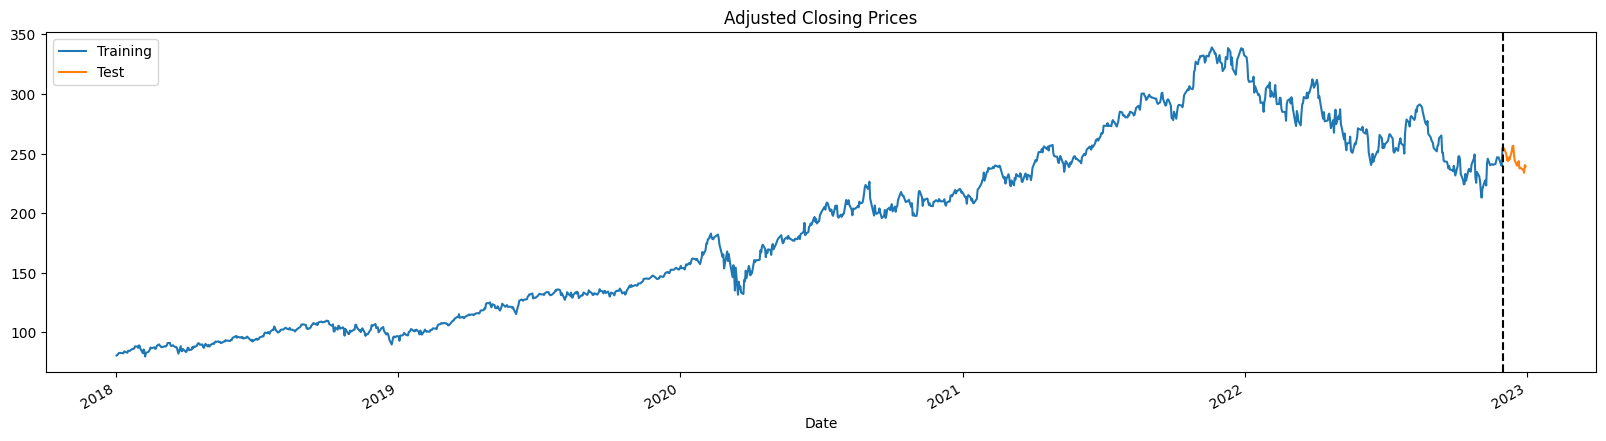

In [11]:
#We will make a prediction first with MSFT 

stock_list = ['MSFT', 'MMC', 'NI', 'BAX', 'CNP', 'TGT', 'JPM', 'BA']
close_df=get_data("20180101","20230101",stock_list)
close_df=close_df[['MSFT']]
close_df.head()

# We will split the data in train and test set and plot the stock price
date="20221201"
plot_close(close_df, date)

In [14]:
#Store all the values
X_train, X_test, y_train, y_test, X, y=prepare_data(close_df, date)


(1236, 2) (1236,)
(21, 2) (21,)


We'll try to fit a model but use a gridsearch in order to find the best parameters. 

In [19]:
model = XGBRegressor()
model.fit(X_train, y_train)

param_grid = {
    
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [20]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Let's use this model and add early stopping in order to avoid overfitting:

In [22]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=500, early_stopping_rounds=50, learning_rate=0.01, max_depth=7)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test,y_test)], verbose=True)

[0]	validation_0-rmse:200.96116	validation_1-rmse:242.22974
[1]	validation_0-rmse:198.96944	validation_1-rmse:239.86210
[2]	validation_0-rmse:196.99737	validation_1-rmse:237.50959
[3]	validation_0-rmse:195.04445	validation_1-rmse:235.16242
[4]	validation_0-rmse:193.11106	validation_1-rmse:232.83862
[5]	validation_0-rmse:191.19672	validation_1-rmse:230.53070
[6]	validation_0-rmse:189.30207	validation_1-rmse:228.28367
[7]	validation_0-rmse:187.42565	validation_1-rmse:226.02246
[8]	validation_0-rmse:185.56853	validation_1-rmse:223.82019
[9]	validation_0-rmse:183.72933	validation_1-rmse:221.60320
[10]	validation_0-rmse:181.90884	validation_1-rmse:219.39898
[11]	validation_0-rmse:180.10610	validation_1-rmse:217.21355
[12]	validation_0-rmse:178.32146	validation_1-rmse:215.05332
[13]	validation_0-rmse:176.55495	validation_1-rmse:212.95909
[14]	validation_0-rmse:174.80565	validation_1-rmse:210.84177
[15]	validation_0-rmse:173.07349	validation_1-rmse:208.72371
[16]	validation_0-rmse:171.35879	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

We'll now see how the RMSE-score looks like:

In [23]:
y_pred = xgb.predict(X_test)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")


RMSE: 4.435564333638648


Let's also make a graph to visualize the output

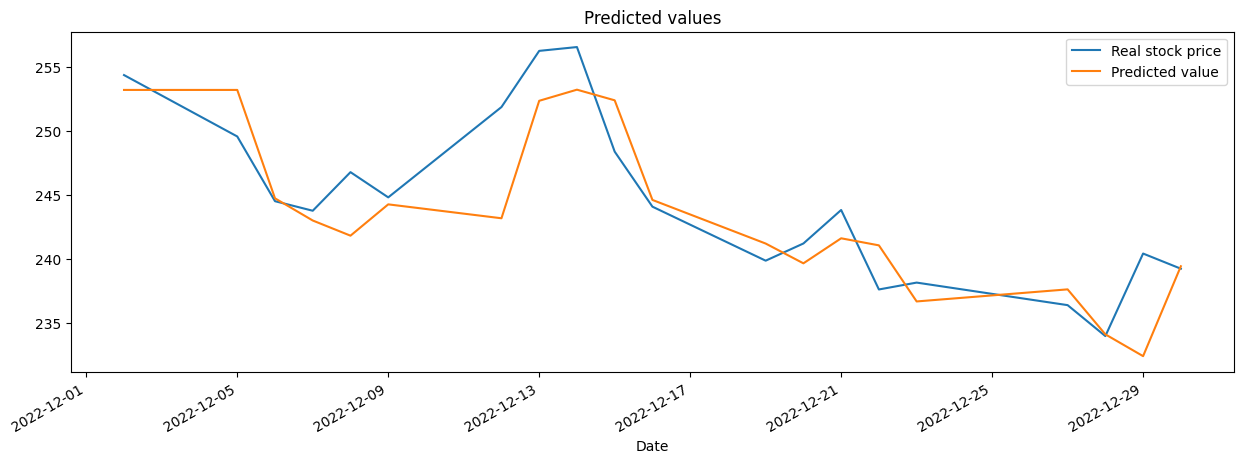

In [25]:
train,test=split(close_df,date)
test['prediction'] = xgb.predict(X_test)
test['prediction'] = xgb.predict(X_test)
df = close_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df.tail(20)[['MSFT']].plot(figsize=(15, 5)) #month
df.tail(20)['prediction'].plot(ax=ax)
plt.legend(['Real stock price', 'Predicted value'])
ax.set_title('Predicted values')
plt.show()

We are happy with this result. Hence we can finalize the model by using all the data

In [24]:
#Finalization
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=500, early_stopping_rounds=50, learning_rate=0.01, max_depth=7)
xgb.fit(X, y, eval_set=[(X, y)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

We can now make a prediction for the 5 coming days:

In [26]:
def predict(X):
    """
    CAREFUL!!
    This function will only predict the future 5 business days 
    as from January 1st, 2023.  
    """
    date_list = [pd.to_datetime('2023-01-03'), pd.to_datetime('2023-01-04'), pd.to_datetime('2023-01-05'), pd.to_datetime('2023-01-06'), pd.to_datetime('2023-01-09')]
    start_values = {'t-1': xgb.predict(X.iloc[-1:])[0], 't-2': X.iloc[-1,0]}

    # Loop over the next five days
    for day in date_list:
        values = {'t-1': xgb.predict(X.iloc[-1:])[0], 't-2': X.iloc[-1,0]}
        X = X.append(pd.DataFrame(values, index=[day]))
    
    y_predict=xgb.predict(X.tail())
    return y_predict

y_predict=predict(X)   

We can now also compare with the actual values: 

In [33]:
stock_list = ['MSFT', 'MMC', 'NI', 'BAX', 'CNP', 'TGT', 'JPM', 'BA']
close_df=get_data("20230101","20230110",stock_list)
future=close_df[['MSFT']]
future['predicted']=y_predict
future


,MSFT,predicted
Date,,
2023-01-03,238.981430,239.425385
2023-01-04,228.527618,239.014359
2023-01-05,221.754562,238.516998
2023-01-06,224.368011,238.548660
2023-01-09,226.552551,238.455124
